In [1]:
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed:
%autoreload 2

In [54]:
# General imports
from pathlib import Path
import numpy as np
import xarray as xr
from numbers import Number

# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["figure.facecolor"] = "white"


# power_perceiver imports
from power_perceiver.load_prepared_batches.prepared_dataset import PreparedDataset
from power_perceiver.consts import BatchKey
from power_perceiver.load_prepared_batches.data_loader import HRVSatellite, PV
from power_perceiver.xr_batch_processor import SelectPVSystemsNearCenterOfImage
from power_perceiver.np_batch_processor import EncodeSpaceTime
from power_perceiver.transforms.satellite import PatchSatellite
from power_perceiver.transforms.pv import PVPowerRollingWindow

In [3]:
DATA_PATH = Path("~/dev/ocf/power_perceiver/data_for_testing/").expanduser()
assert DATA_PATH.exists()

In [27]:
hrv_satellite_patched = HRVSatellite(
    data_path=DATA_PATH,
    transforms=[PatchSatellite()],
)

In [28]:
hrv_dataset_patched = hrv_satellite_patched[0]
hrv_dataset_patched

<xarray.Dataset>
Dimensions:          (example: 32, channel: 1, time: 31, y: 16, x: 16, patch: 16)
Coordinates:
    channel_name     (example, channel) object 'HRV' 'HRV' 'HRV' ... 'HRV' 'HRV'
    time_utc         (example, time) datetime64[ns] 2020-09-12T09:05:00 ... 2...
    x_geostationary  (example, x) float32 -8.446e+05 -8.406e+05 ... -6.296e+05
    x_osgb           (example, y, x) float32 2.017e+05 2.062e+05 ... 4.742e+05
    y_geostationary  (example, y) float32 4.819e+06 4.823e+06 ... 4.748e+06
    y_osgb           (example, y, x) float32 6.417e+05 6.412e+05 ... 4.533e+05
  * patch            (patch) MultiIndex
  - y_patch          (patch) int64 0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3
  - x_patch          (patch) int64 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3
Dimensions without coordinates: example, channel, time, y, x
Data variables:
    data             (example, time, channel, y, x, patch) int16 260 260 ... 138

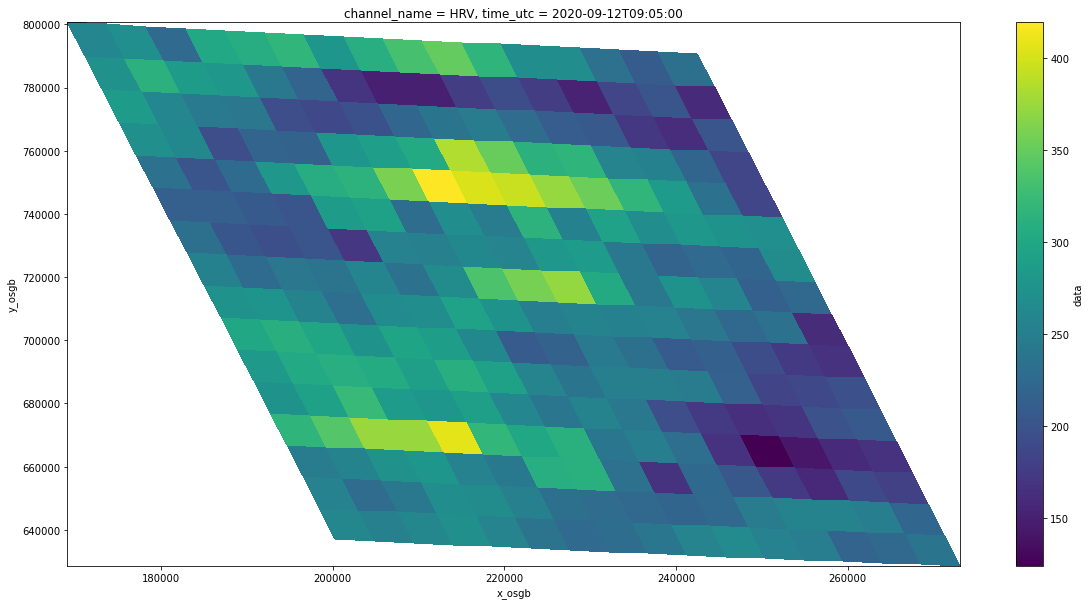

In [30]:
hrv_dataset_patched["data"].isel(example=0, channel=0, time=0).mean("patch").plot.pcolormesh(
    x="x_osgb",
    y="y_osgb"
)


In [81]:
dataset = PreparedDataset(
    data_path=DATA_PATH,
    data_loaders=[
        HRVSatellite(
            transforms=[PatchSatellite()]
            ), 
        PV(
            transforms=[PVPowerRollingWindow()]
            ),
    ],
    xr_batch_processors=[SelectPVSystemsNearCenterOfImage()],
    np_batch_processors=[EncodeSpaceTime()]
)

In [82]:
%%time
BATCH_IDX = 0
np_batch = dataset[BATCH_IDX]

CPU times: user 222 ms, sys: 0 ns, total: 222 ms
Wall time: 221 ms


In [89]:
np_batch[BatchKey.hrvsatellite_x_osgb_fourier].shape

(32, 16, 16, 8)

In [83]:
EXAMPLE_IDX = 0
np.sum(np_batch[BatchKey.pv_mask][EXAMPLE_IDX])

56

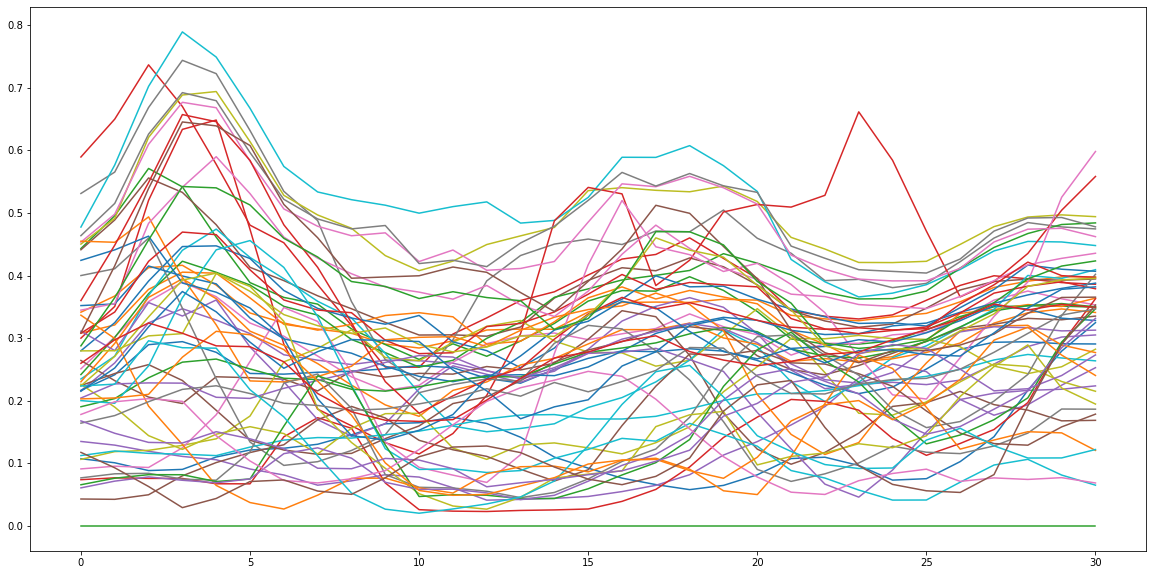

In [84]:
EXAMPLE_IDX = 0

plt.plot(np_batch[BatchKey.pv][EXAMPLE_IDX, :, np_batch[BatchKey.pv_mask][EXAMPLE_IDX]].T);

In [78]:
np_batch[BatchKey.pv].shape

(32, 31, 128)

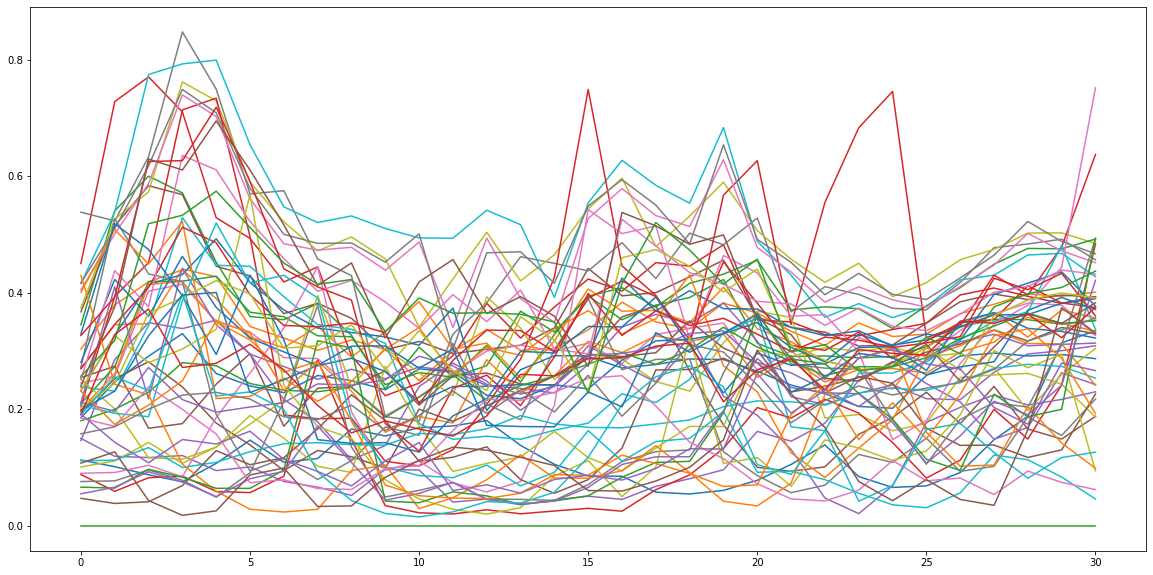

In [79]:
plt.plot(np_batch[BatchKey.pv][EXAMPLE_IDX, :, np_batch[BatchKey.pv_mask][EXAMPLE_IDX]].T);

In [85]:
np_batch[BatchKey.hrvsatellite].shape

(32, 31, 1, 16, 16, 16)

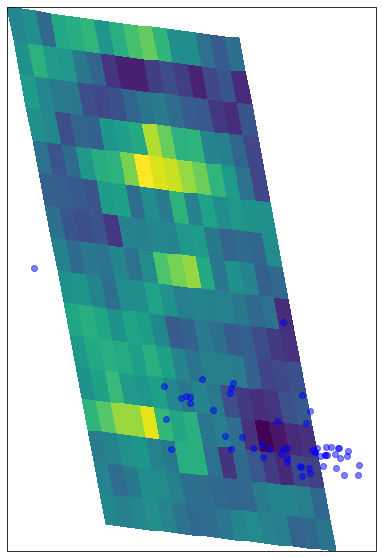

In [86]:

osgb_ax = plt.axes(projection=ccrs.OSGB(approx=False))

osgb_ax.pcolormesh(
    np_batch[BatchKey.hrvsatellite_x_osgb][EXAMPLE_IDX],
    np_batch[BatchKey.hrvsatellite_y_osgb][EXAMPLE_IDX],
    np_batch[BatchKey.hrvsatellite][EXAMPLE_IDX, 0, 0].mean(axis=-1),   
)

osgb_ax.scatter(
    x=np_batch[BatchKey.pv_x_osgb][EXAMPLE_IDX],
    y=np_batch[BatchKey.pv_y_osgb][EXAMPLE_IDX],
    color="blue",
    alpha=0.5,
)

In [38]:
[key.name for key in np_batch.keys()]

['hrvsatellite',
 'hrvsatellite_time_utc',
 'hrvsatellite_x_osgb',
 'hrvsatellite_y_osgb',
 'pv',
 'pv_system_row_number',
 'pv_id',
 'pv_capacity_wp',
 'pv_mask',
 'pv_time_utc',
 'pv_x_osgb',
 'pv_y_osgb',
 'hrvsatellite_x_osgb_fourier',
 'pv_x_osgb_fourier',
 'hrvsatellite_y_osgb_fourier',
 'pv_y_osgb_fourier',
 'hrvsatellite_time_utc_fourier',
 'pv_time_utc_fourier']

In [39]:
np_batch[BatchKey.hrvsatellite_x_osgb_fourier].shape

(32, 16, 16, 8)

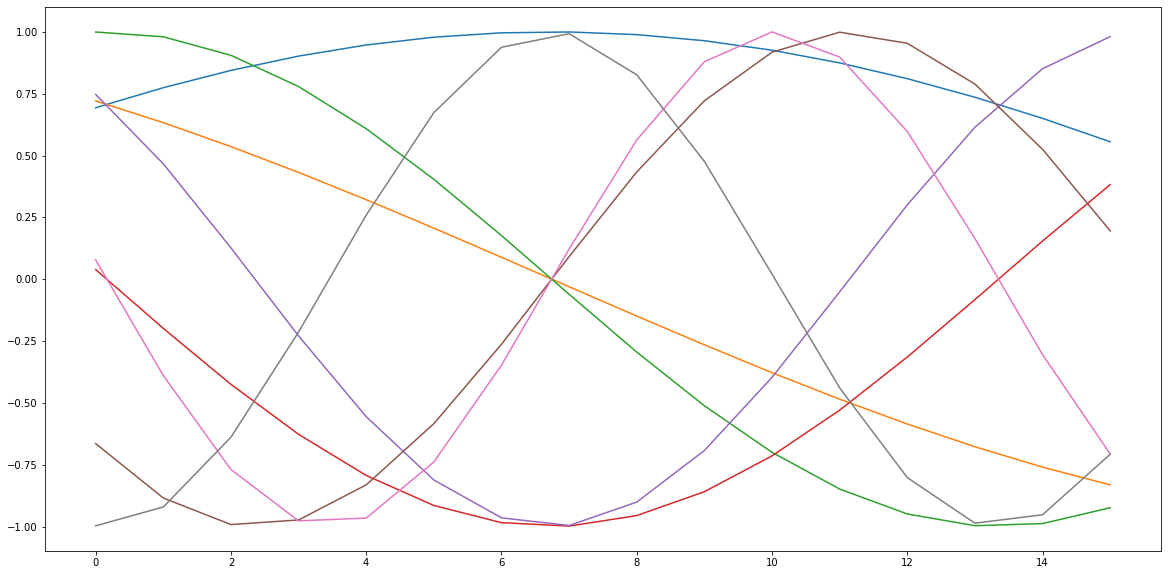

In [40]:
plt.plot(np_batch[BatchKey.hrvsatellite_x_osgb_fourier][0, 0]);

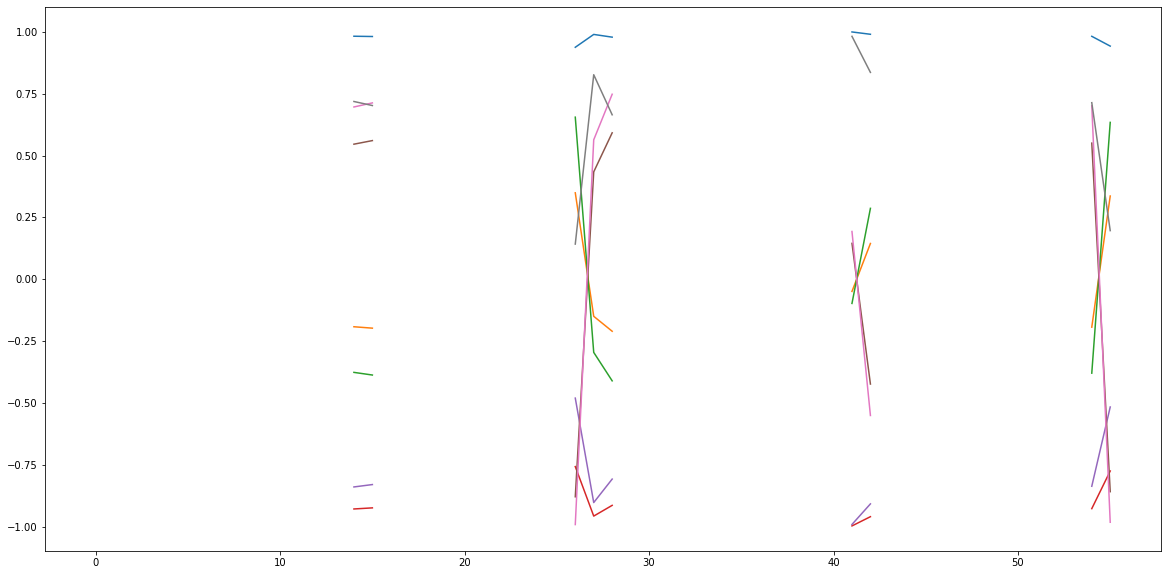

In [41]:
plt.plot(np_batch[BatchKey.pv_x_osgb_fourier][0]);

In [42]:
np_batch[BatchKey.pv_x_osgb_fourier].shape

(32, 128, 8)